# Introduction


Ensuring the safety of workers on construction sites is paramount, with the proper use of Personal Protective Equipment (PPE) such as hardhats serving as a critical component in preventing workplace injuries and fatalities. However, manual monitoring of PPE compliance can be labor-intensive and prone to human error. To address this challenge, this project focuses on the development of an automated system for detecting whether workers are wearing appropriate PPE, specifically hardhats, using advanced computer vision techniques.


Three distinct models were evaluated to achieve this objective: a fine-tuned YOLO model, Faster R-CNN, and a standard Convolutional Neural Network (CNN). Among these, the YOLOv8 model demonstrated superior performance in accurately identifying hardhats and in a much faster speed, followed by Faster R-CNN and CNN respectively. The comparative analysis highlights the effectiveness of real-time object detection algorithms in enhancing safety protocols on construction sites, paving the way for more reliable and efficient PPE compliance monitoring systems.

#### Download dataset

In [ ]:
# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files('snehilsanyal/construction-site-safety-image-dataset-roboflow', path='D:/Downloads/1517_dataset', unzip=True)

# print("Dataset downloaded and extracted!")

#### Load data

In [ ]:
import os
import glob
import random
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def get_image_label_pairs(folder):
    images_path = os.path.join(folder, 'images')
    labels_path = os.path.join(folder, 'labels')
    image_files = glob.glob(os.path.join(images_path, '*.jpg'))
    pairs = []
    for image_file in image_files:
        filename = os.path.basename(image_file)
        label_file = os.path.join(labels_path, os.path.splitext(filename)[0] + '.txt')
        if os.path.exists(label_file):
            pairs.append((image_file, label_file))
    return pairs

dataset_path = r'D:\Downloads\1517_dataset\css-data'

train_pairs = get_image_label_pairs(os.path.join(dataset_path, 'train'))
valid_pairs = get_image_label_pairs(os.path.join(dataset_path, 'valid'))
test_pairs = get_image_label_pairs(os.path.join(dataset_path, 'test'))

print(f"Number of training images: {len(train_pairs)}")
print(f"Number of validation images: {len(valid_pairs)}")
print(f"Number of test images: {len(test_pairs)}")

Number of training images: 2605
Number of validation images: 114
Number of test images: 82


#### Assessing data label distribution balance across training, validation, and testing sets

In [29]:
label_descriptions = {
    0: "Hardhat",
    1: "Mask",
    2: "NO-Hardhat",
    3: "NO-Mask",
    4: "NO-Safety Vest",
    5: "Person",
    6: "Safety Cone",
    7: "Safety Vest",
    8: "Machinery",
    9: "Vehicle"
}

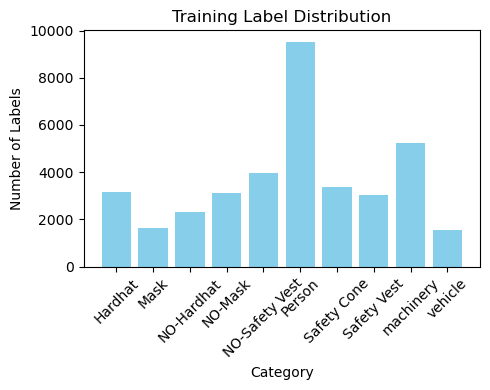

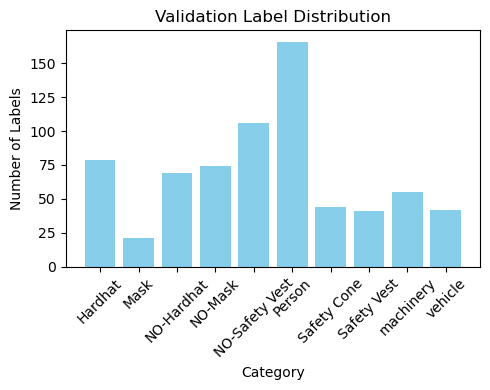

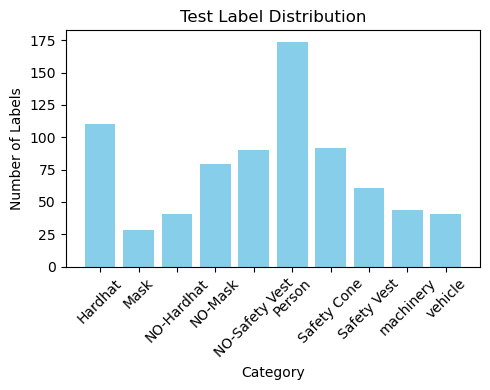

In [28]:
def extract_labels(label_file):
    with open(label_file, 'r') as file:
        labels = [int(line.split()[0]) for line in file.readlines()]
    return labels

def count_labels(pairs):
    label_counts = Counter()
    for _, label_file in pairs:
        labels = extract_labels(label_file)
        label_counts.update(labels)
    return label_counts

train_label_counts = count_labels(train_pairs)
valid_label_counts = count_labels(valid_pairs)
test_label_counts = count_labels(test_pairs)

def plot_label_distribution(label_counts, title):
    categories = [label_descriptions[label] for label in sorted(label_counts.keys())]
    counts = [label_counts[label] for label in sorted(label_counts.keys())]
    plt.figure(figsize=(5, 4))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Category')
    plt.ylabel('Number of Labels')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot the distributions
plot_label_distribution(train_label_counts, 'Training Label Distribution')
plot_label_distribution(valid_label_counts, 'Validation Label Distribution')
plot_label_distribution(test_label_counts, 'Test Label Distribution')

As observed, there is a distribution imbalance between instances with hard hats and those without in the test set. We believe this imbalance is not a significant issue for two reasons. First, the imbalance in the test set does not negatively impact the model's performance, as the model was trained on data that reflects real-world conditions. Second, the distribution in the test set mirrors real-world scenarios, indicating that no further adjustments are necessary at this time. 

#### Visualize some sample data

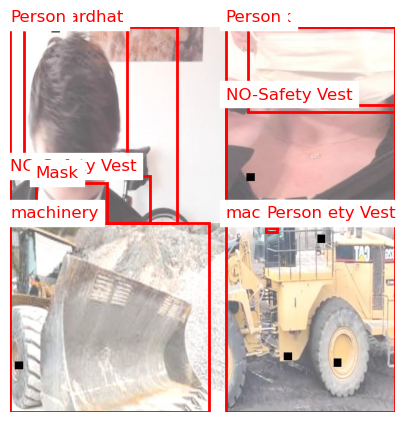

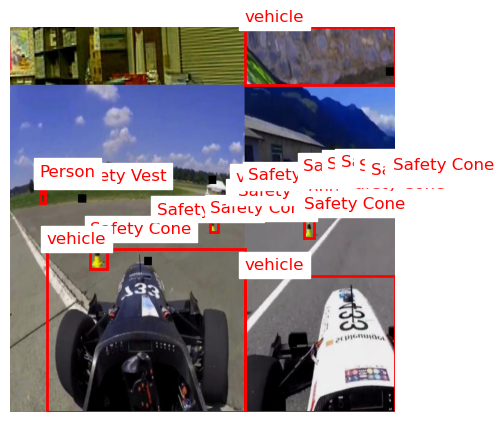

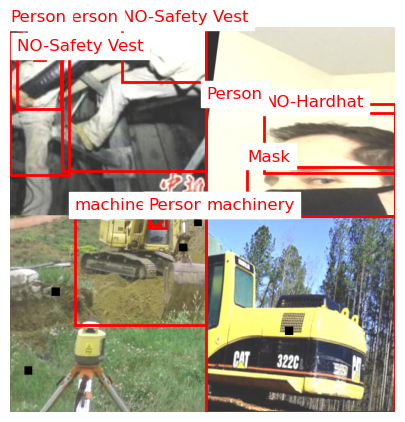

In [37]:
def read_labels(label_file):
    labels = []
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                class_id = int(parts[0])
                bbox = list(map(float, parts[1:]))
                labels.append((class_id, bbox))
    return labels

def plot_image_with_boxes(image_file, label_file):
    image = Image.open(image_file)
    labels = read_labels(label_file)
    fig, ax = plt.subplots(1, figsize=(8, 5))
    ax.imshow(image)
    img_width, img_height = image.size

    for class_id, bbox in labels:
        x_center, y_center, width, height = bbox
        # normalized coordinates to pixel coordinates
        x_center *= img_width
        y_center *= img_height
        width *= img_width
        height *= img_height
        # top left corner of the bounding box
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        # rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2,
                                 edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        # class label
        ax.text(x_min, y_min - 10, label_descriptions[class_id],
                color='red', fontsize=12, backgroundcolor='white')
    plt.axis('off')
    plt.show()


random.seed(1234)
sample_pairs = random.sample(train_pairs, 3)

for image_file, label_file in sample_pairs:
    plot_image_with_boxes(image_file, label_file)


#### Filtering out "Person", "Hardhat", and "NO-Hardhat" class

In [ ]:
import shutil

label_descriptions = {
    0: 'Hardhat',
    1: 'Mask',
    2: 'NO-Hardhat',
    3: 'NO-Mask',
    4: 'NO-Safety Vest',
    5: 'Person',
    6: 'Safety Cone',
    7: 'Safety Vest',
    8: 'machinery',
    9: 'vehicle'
}

class_mapping = {0: 0, 2: 1, 5: 2}  # old class IDs to new class IDs
desired_classes = class_mapping.keys()

def get_all_images_labels(folder):
    images_path = os.path.join(folder, 'images')
    labels_path = os.path.join(folder, 'labels')
    image_files = glob.glob(os.path.join(images_path, '*.jpg'))
    pairs = []
    for image_file in image_files:
        filename = os.path.basename(image_file)
        label_file = os.path.join(labels_path, os.path.splitext(filename)[0] + '.txt')
        pairs.append((image_file, label_file))
    return pairs

def process_dataset_split(pairs, class_mapping, output_dataset_path, split_name):
    for image_file, label_file in pairs:
        if os.path.exists(label_file):
            with open(label_file, 'r') as f:
                lines = f.readlines()
        else:
            lines = []
        
        new_lines = []
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0])
            if class_id in class_mapping:
                # remap class ID
                new_class_id = class_mapping[class_id]
                new_line = ' '.join([str(new_class_id)] + parts[1:])
                new_lines.append(new_line)
        
        # check if output directories exist
        image_output_dir = os.path.join(output_dataset_path, split_name, 'images')
        label_output_dir = os.path.join(output_dataset_path, split_name, 'labels')
        os.makedirs(image_output_dir, exist_ok=True)
        os.makedirs(label_output_dir, exist_ok=True)
        
        image_output_path = os.path.join(image_output_dir, os.path.basename(image_file))
        if not os.path.exists(image_output_path):
            shutil.copy(image_file, image_output_path)
        
        label_output_path = os.path.join(label_output_dir, os.path.basename(label_file))
        with open(label_output_path, 'w') as f:
            f.write('\n'.join(new_lines))

dataset_path = r'D:\Downloads\1517_dataset\css-data'
output_dataset_path = r'D:\Downloads\1517_dataset\css-data-filtered'

train_pairs = get_all_images_labels(os.path.join(dataset_path, 'train'))
valid_pairs = get_all_images_labels(os.path.join(dataset_path, 'valid'))
test_pairs = get_all_images_labels(os.path.join(dataset_path, 'test'))

process_dataset_split(train_pairs, class_mapping, output_dataset_path, 'train')
process_dataset_split(valid_pairs, class_mapping, output_dataset_path, 'valid')
process_dataset_split(test_pairs, class_mapping, output_dataset_path, 'test')

print("Filtering and remapping completed successfully!")

Filtering and remapping completed successfully!


## YOLO

#### Create data.yaml file for Yolo-v8

In [ ]:
import yaml
dataset_filtered_path = r'D:/Downloads/1517_dataset/css-data-filtered'

train_images = os.path.join(dataset_filtered_path, 'train', 'images')
val_images = os.path.join(dataset_filtered_path, 'valid', 'images')
test_images = os.path.join(dataset_filtered_path, 'test', 'images')

class_names = {
    0: 'Hardhat',
    1: 'NO-Hardhat',
    2: 'Person'
}

data_dict = {
    'train': train_images.replace('\\', '/'),
    'val': val_images.replace('\\', '/'),
    'test': test_images.replace('\\', '/'),
    'names': class_names
}

data_yaml_output_path = os.path.join(dataset_filtered_path, 'data.yaml')

with open(data_yaml_output_path, 'w') as file:
    yaml.dump(data_dict, file, sort_keys=False)

print(f"data.yaml has been created at: {data_yaml_output_path}")

data.yaml has been created at: D:/Downloads/1517_dataset/css-data-filtered\data.yaml


#### Start tuning

In [ ]:
# load the pretrained YOLOv8 model (Initialise the YOLOv8 model using the pre training weights in the yolov8n.pt file.)
# used yolov8n (nano) to save time
from ultralytics import YOLO

model = YOLO('yolov8n.pt') 
model.info()

YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

##### Since there is enough data in the training set, no layers will be frozen

In [32]:
print(model.model)

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

start training

In [ ]:
results = model.train(
    data= data_yaml_output_path, 
    epochs=50,       
    imgsz=640,      
    batch= 32,     
    name='yolov8_hardhat_detection',
    verbose=True
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 56.6MB/s]


New https://pypi.org/project/ultralytics/8.3.29 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.27  Python-3.12.3 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=D:/Downloads/1517_dataset/css-data-filtered\data.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8_hardhat_detection, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=

100%|██████████| 5.35M/5.35M [00:00<00:00, 52.2MB/s]


AMP: checks passed 


train: Scanning D:\Downloads\1517_dataset\css-data-filtered\train\labels.cache... 2605 images, 70 backgrounds, 0 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]
val: Scanning D:\Downloads\1517_dataset\css-data-filtered\valid\labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to runs\detect\yolov8_hardhat_detection\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\yolov8_hardhat_detection
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.77G      1.314      2.214      1.385        145        640: 100%|██████████| 82/82 [00:25<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.53it/s]

                   all        114        314      0.744       0.21      0.339      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.77G      1.265      1.643      1.357         92        640: 100%|██████████| 82/82 [00:19<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all        114        314      0.531      0.386      0.407      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.47G      1.249      1.564      1.351        102        640: 100%|██████████| 82/82 [00:22<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all        114        314      0.462      0.392      0.344      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.04G      1.244      1.515      1.342         95        640: 100%|██████████| 82/82 [00:22<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all        114        314      0.553      0.386      0.406      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.71G      1.221      1.453      1.325        119        640: 100%|██████████| 82/82 [00:22<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all        114        314      0.658      0.431      0.464      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.93G      1.184      1.402      1.318         96        640: 100%|██████████| 82/82 [00:23<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all        114        314       0.65      0.478      0.513      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.67G       1.17      1.348      1.303         66        640: 100%|██████████| 82/82 [00:23<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all        114        314      0.691      0.517      0.571      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.96G       1.15      1.308      1.284        100        640: 100%|██████████| 82/82 [00:23<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all        114        314      0.737      0.489      0.561      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      5.32G      1.127      1.233       1.27        106        640: 100%|██████████| 82/82 [00:23<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all        114        314      0.817      0.521      0.593      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.68G      1.115      1.213      1.257        145        640: 100%|██████████| 82/82 [00:23<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all        114        314      0.799      0.516      0.611      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.46G       1.09      1.159       1.24         96        640: 100%|██████████| 82/82 [00:24<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all        114        314      0.816      0.565      0.651      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.72G      1.075      1.127      1.222        107        640: 100%|██████████| 82/82 [00:23<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all        114        314      0.742      0.526       0.56      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.72G      1.064      1.113      1.222        150        640: 100%|██████████| 82/82 [00:22<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all        114        314       0.79      0.538      0.632      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.72G      1.061        1.1      1.221        106        640: 100%|██████████| 82/82 [00:22<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all        114        314      0.767      0.555      0.618       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       5.4G      1.033      1.056      1.201         99        640: 100%|██████████| 82/82 [00:22<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all        114        314      0.817      0.558      0.642      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.74G       1.03      1.036      1.199         96        640: 100%|██████████| 82/82 [00:22<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all        114        314      0.811      0.526      0.589      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      5.18G      1.024      1.025      1.194        188        640: 100%|██████████| 82/82 [00:22<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all        114        314      0.777      0.593      0.675      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.92G      1.015      1.002       1.19         75        640: 100%|██████████| 82/82 [00:22<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all        114        314      0.804      0.589      0.665      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      5.12G      1.013     0.9926      1.178        109        640: 100%|██████████| 82/82 [00:21<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all        114        314      0.851      0.613      0.677      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      5.31G          1      0.968      1.182         86        640: 100%|██████████| 82/82 [00:22<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all        114        314      0.863      0.613        0.7      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.39G     0.9849     0.9426      1.168        143        640: 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all        114        314      0.864      0.612       0.72       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.71G     0.9665     0.9292      1.155         92        640: 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all        114        314       0.82      0.605      0.703      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.65G     0.9698     0.9223      1.163        127        640: 100%|██████████| 82/82 [00:22<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all        114        314      0.844      0.627        0.7      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.46G     0.9441     0.9028      1.145        105        640: 100%|██████████| 82/82 [00:21<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all        114        314      0.856      0.612      0.693      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.85G     0.9561      0.892      1.146        145        640: 100%|██████████| 82/82 [00:21<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all        114        314       0.86      0.612      0.706      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.91G     0.9345      0.877      1.137        118        640: 100%|██████████| 82/82 [00:22<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all        114        314      0.852      0.602      0.696      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.74G     0.9242     0.8572       1.13        161        640: 100%|██████████| 82/82 [00:22<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all        114        314      0.822      0.674      0.768      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.79G     0.9243     0.8496       1.13        140        640: 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all        114        314      0.891       0.67      0.779       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      5.37G     0.9095     0.8369      1.121        108        640: 100%|██████████| 82/82 [00:23<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all        114        314      0.874      0.641      0.736      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      5.27G     0.8992     0.8209      1.114        129        640: 100%|██████████| 82/82 [00:23<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all        114        314      0.859      0.683      0.753      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.91G     0.8982     0.8064      1.116        102        640: 100%|██████████| 82/82 [00:22<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all        114        314      0.877      0.682      0.763       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      5.46G     0.8756     0.7871      1.104        105        640: 100%|██████████| 82/82 [00:22<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all        114        314      0.925       0.63      0.751      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.87G      0.879     0.7791      1.102         84        640: 100%|██████████| 82/82 [00:22<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all        114        314      0.892      0.669      0.765      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.65G     0.8813     0.7799      1.097        127        640: 100%|██████████| 82/82 [00:22<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all        114        314      0.864      0.704       0.78      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      5.22G     0.8612     0.7649      1.091         95        640: 100%|██████████| 82/82 [00:23<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all        114        314      0.878      0.642      0.749      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      5.04G     0.8457     0.7528      1.091         99        640: 100%|██████████| 82/82 [00:22<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all        114        314       0.87      0.684      0.782      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      5.19G     0.8395      0.741      1.087         83        640: 100%|██████████| 82/82 [00:23<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all        114        314      0.883      0.636      0.745      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.68G      0.835     0.7389      1.078         76        640: 100%|██████████| 82/82 [00:23<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all        114        314      0.888      0.685      0.771      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.94G     0.8218     0.7211      1.072        177        640: 100%|██████████| 82/82 [00:23<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all        114        314      0.905      0.694      0.799      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      5.17G      0.819     0.7093       1.07        121        640: 100%|██████████| 82/82 [00:22<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all        114        314      0.909      0.651      0.772      0.449


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.42G     0.8406     0.6463      1.081         71        640: 100%|██████████| 82/82 [00:22<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all        114        314      0.892      0.686      0.782      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.39G     0.8143     0.6223      1.065         57        640: 100%|██████████| 82/82 [00:22<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all        114        314      0.884      0.697      0.789      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.37G     0.8076     0.6037      1.063         64        640: 100%|██████████| 82/82 [00:22<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all        114        314      0.872      0.701      0.782      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.14G     0.7966     0.5958      1.051         72        640: 100%|██████████| 82/82 [00:22<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all        114        314      0.921       0.66      0.782      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.47G     0.7832     0.5842      1.039         82        640: 100%|██████████| 82/82 [00:22<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all        114        314      0.862      0.708       0.79      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.23G     0.7811     0.5761      1.038         48        640: 100%|██████████| 82/82 [00:21<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all        114        314      0.901      0.696      0.802      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.26G     0.7613     0.5627      1.031         55        640: 100%|██████████| 82/82 [00:22<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all        114        314       0.86      0.731      0.801      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.31G     0.7609     0.5619      1.034         77        640: 100%|██████████| 82/82 [00:22<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all        114        314      0.918      0.684        0.8      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.37G     0.7399     0.5394       1.02         52        640: 100%|██████████| 82/82 [00:20<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all        114        314      0.873      0.725      0.802      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.34G      0.729     0.5384      1.019         64        640: 100%|██████████| 82/82 [00:20<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all        114        314      0.874      0.728      0.803      0.492



50 epochs completed in 0.340 hours.
Optimizer stripped from runs\detect\yolov8_hardhat_detection\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\yolov8_hardhat_detection\weights\best.pt, 6.3MB

Validating runs\detect\yolov8_hardhat_detection\weights\best.pt...
Ultralytics 8.3.27  Python-3.12.3 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]


                   all        114        314      0.874      0.728      0.802      0.492
               Hardhat         42         79      0.917      0.797      0.895      0.571
            NO-Hardhat         37         69      0.855      0.598      0.664      0.371
                Person         84        166      0.851      0.789      0.847      0.533
Speed: 0.1ms preprocess, 2.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\yolov8_hardhat_detection


### Evaluate trained YOLOv8 model on the test set and visualize the results

In [34]:
from ultralytics import YOLO
import os

# loading the best prams
model_path = 'runs/detect/yolov8_hardhat_detection/weights/best.pt'
model = YOLO(model_path)

data_yaml = r'D:/Downloads/1517_dataset/css-data-filtered/data.yaml'

# eval the model on the test set
metrics = model.val(
    data=data_yaml,  
    split='test',    
    imgsz=640,       
    save_json=True,  
    save=True    
)

print("Evaluation Metrics:")
print(metrics)

Ultralytics 8.3.27  Python-3.12.3 torch-2.4.1 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning D:\Downloads\1517_dataset\css-data-filtered\test\labels.cache... 82 images, 22 backgrounds, 0 corrupt: 100%|██████████| 82/82 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.16it/s]


                   all         82        325      0.881       0.72      0.768      0.463
               Hardhat         30        110      0.968      0.837      0.915      0.588
            NO-Hardhat         25         41      0.851      0.558      0.561      0.287
                Person         59        174      0.822      0.764      0.828      0.515
Speed: 1.6ms preprocess, 5.7ms inference, 0.0ms loss, 1.3ms postprocess per image
Saving runs\detect\val2\predictions.json...
Results saved to runs\detect\val2
Evaluation Metrics:
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001A7CC5E1A60>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,  

In [ ]:
def f1_score(precision, recall):
    if (precision + recall) == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

precision_overall = 0.881
recall_overall = 0.72
precision_hardhat = 0.968
recall_hardhat = 0.837
precision_no_hardhat = 0.851
recall_no_hardhat = 0.558
precision_person = 0.822
recall_person = 0.764

f1_overall = f1_score(precision_overall, recall_overall)
f1_hardhat = f1_score(precision_hardhat, recall_hardhat)
f1_no_hardhat = f1_score(precision_no_hardhat, recall_no_hardhat)
f1_person = f1_score(precision_person, recall_person)

print("F1 Score (Overall):", f1_overall)
print("F1 Score (Hardhat):", f1_hardhat)
print("F1 Score (NO-Hardhat):", f1_no_hardhat)
print("F1 Score (Person):", f1_person)

F1 Score (Overall): 0.7924047470331043
F1 Score (Hardhat): 0.8977462603878116
F1 Score (NO-Hardhat): 0.6740354861603975
F1 Score (Person): 0.7919394703657


#### Explanation of Metrics:

- **P (Precision)**: The proportion of correctly predicted positive samples among all predicted positive samples.
- **R (Recall)**: The proportion of correctly predicted positive samples among all actual positive samples.
- **mAP50**: Mean Average Precision at an IoU (Intersection over Union) threshold of 0.5.
- **mAP50-95**: Mean Average Precision across different IoU thresholds ranging from 0.5 to 0.95.

##### Detailed Performance by Category:
- **Overall (all)**: 
  - Precision: 0.881
  - Recall: 0.72
  - mAP50: 0.768
  - mAP50-95: 0.463
  - F1 Score: 0.792

- **Hardhat**:
  - Precision: 0.968
  - Recall: 0.837
  - mAP50: 0.915
  - mAP50-95: 0.588
  - F1 Score: 0.898

- **NO-Hardhat**:
  - Precision: 0.851
  - Recall: 0.558
  - mAP50: 0.561
  - mAP50-95: 0.287
  - F1 Score: 0.674

- **Person**:
  - Precision: 0.822
  - Recall: 0.764
  - mAP50: 0.828
  - mAP50-95: 0.515
  - F1 Score: 0.792



From these data, it can be seen that the helmet category performs best, with high precision and recall. The relatively low recall for no helmet indicates that the model has some miss detection for this category.



##### The processing speed for each image: 
  
Preprocessing: 1.6 ms  
Inference (detection): 5.7 ms  
Post-processing: 1.3 ms  


In [33]:
test_images = os.path.join('D:/Downloads/1517_dataset/css-data-filtered/test/images')

results = model.predict(
    source=test_images, 
    imgsz=640,          
    conf=0.25,         
    save=True,          
    save_txt=True,       
    save_conf=True  
)


image 1/82 D:\Downloads\1517_dataset\css-data-filtered\test\images\-4405-_png_jpg.rf.82b5c10b2acd1cfaa24259ada8e599fe.jpg: 640x640 (no detections), 22.0ms
image 2/82 D:\Downloads\1517_dataset\css-data-filtered\test\images\000005_jpg.rf.96e9379ccae638140c4a90fc4b700a2b.jpg: 640x640 1 person, 1 horse, 6.0ms
image 3/82 D:\Downloads\1517_dataset\css-data-filtered\test\images\002551_jpg.rf.ce4b9f934161faa72c80dc6898d37b2d.jpg: 640x640 3 persons, 4.0ms
image 4/82 D:\Downloads\1517_dataset\css-data-filtered\test\images\003357_jpg.rf.9867f91e88089bb68dc95947d5116d14.jpg: 640x640 1 person, 1 potted plant, 5.1ms
image 5/82 D:\Downloads\1517_dataset\css-data-filtered\test\images\004063_jpg.rf.1b7cdc4035bcb24ef69b8798b444053e.jpg: 640x640 5 persons, 6.1ms
image 6/82 D:\Downloads\1517_dataset\css-data-filtered\test\images\004763_jpg.rf.46484e6ca73caeaa9de45822cf1085a9.jpg: 640x640 3 persons, 1 tie, 6.0ms
image 7/82 D:\Downloads\1517_dataset\css-data-filtered\test\images\006463_jpg.rf.02f19082420ec

#### Some sample predictions by model

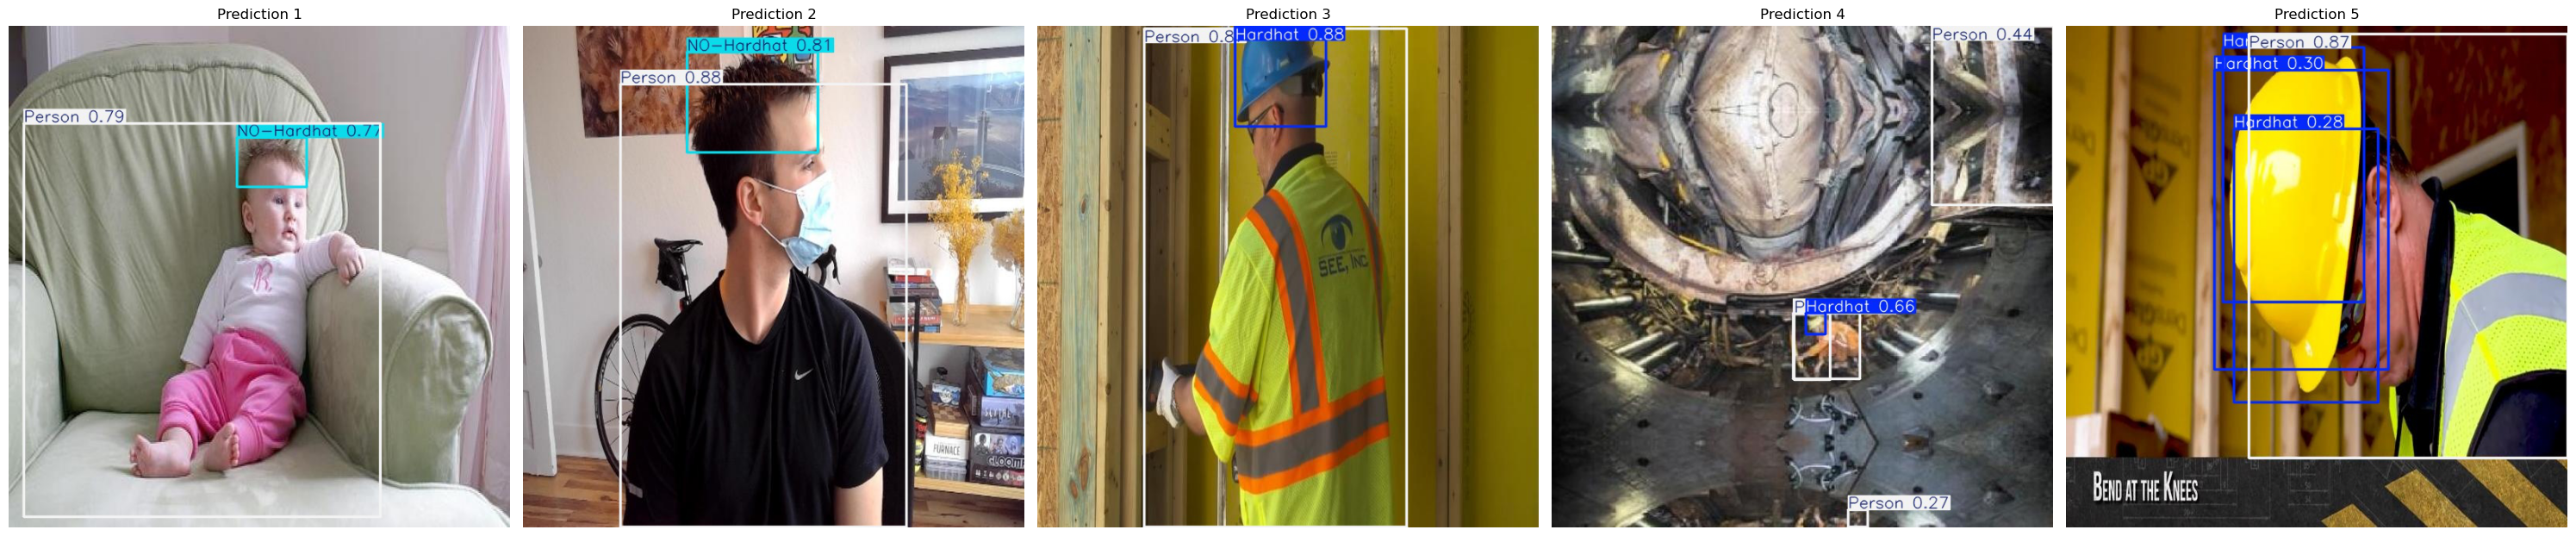

In [ ]:
predict_dir = 'runs/detect/predict'

if not os.path.exists(predict_dir):
    raise FileNotFoundError(f"Cannot find the prediction directory at {predict_dir}")

image_files = [os.path.join(predict_dir, f) for f in os.listdir(predict_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

if not image_files:
    raise FileNotFoundError(f"No prediction images found in {predict_dir}")

num_samples = 5 
sample_images = random.sample(image_files, min(num_samples, len(image_files)))

plt.figure(figsize=(30, 20))
for idx, img_path in enumerate(sample_images, 1):
    image = Image.open(img_path)
    plt.subplot(1, num_samples, idx)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Prediction {idx}")
plt.tight_layout()
plt.show()

In most cases, the model performed well. However, in certain instances, such as prediction example 5, it correctly identified a person with 87% confidence but incorrectly identified three 'Hardhats' with confidence levels of 30%, 28%, and  ??%. This indicates potential issues related to post processing issues such as confidence filtering and non maximum suppression within the model.


**Conclusion:**  
  
Our YOLO model demonstrated solid overall performance, especially in detecting hardhats and persons. With an overall precision of 0.881, recall of 0.72, and an mAP50 of 0.768, the model exhibits high accuracy in identifying positive cases, particularly for the hardhat category, where both precision (0.968) and recall (0.837) are notably high. However, detection in the "NO-Hardhat" category shows limitations, with a relatively low recall (0.558), suggesting missed detections that could affect safety monitoring. Additionally, analysis of prediction examples reveals occasional misclassifications, such as incorrect identification of hardhats at low confidence levels, which could stem from post processing challenges like confidence filtering and non-maximum suppression. Overall, the model provides reliable detection capabilities, but improvements in post processing and recall for specific categories may further enhance its performance.